### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

In [2]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data


current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reflex      1206 non-null   int64 
 1   focus       1206 non-null   int32 
 2   hp          1206 non-null   int64 
 3   cha         1206 non-null   int64 
 4   con         1206 non-null   int64 
 5   ac          1206 non-null   int64 
 6   wis         1206 non-null   int64 
 7   will        1206 non-null   int64 
 8   dex         1206 non-null   int64 
 9   str         1206 non-null   int64 
 10  book        1206 non-null   object
 11  fortitude   1206 non-null   int64 
 12  int         1206 non-null   int64 
 13  level       1206 non-null   int64 
 14  perception  1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [4]:
df.head()

,reflex,focus,hp,cha,con,ac,wis,will,dex,str,book,fortitude,int,level,perception
0,19,1,215,1,5,29,2,17,2,7,Pathfinder Bestiary,22,1,10,20
1,14,0,220,1,5,28,2,16,0,9,Pathfinder Bestiary,21,-4,10,16
2,17,0,175,-2,6,25,3,15,3,7,Pathfinder Bestiary,20,-4,8,17
3,29,1,315,6,5,41,5,32,4,7,Pathfinder Bestiary,30,6,17,30
4,10,1,20,1,1,16,1,4,3,-5,Pathfinder Bestiary,6,-1,1,6


## Train test split

### Chronological split

In [5]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/random_forest")

In [6]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [7]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [8]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [9]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

### With chronological split

In [10]:
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [11]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 2.12
RMSE: 1.45
MAE: 1.16


In [13]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [14]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.12
RMSE: 1.45

Round type: round
MSE: 2.38
RMSE: 1.54

Round type: 0.33
MSE: 2.13
RMSE: 1.46

Round type: 0.45
MSE: 2.12
RMSE: 1.46



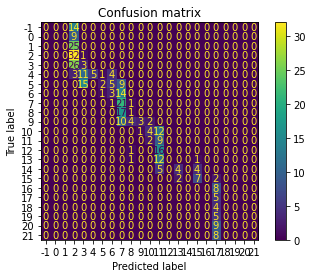

In [15]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [16]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [17]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.6s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.6s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   2.3s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   2.3s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   2.5s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   3.0s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   2.7s
[CV] END .max_depth=None, max_features=0.1, n_

[CV] END ...max_depth=30, max_features=0.1, n_estimators=800; total time=   2.7s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   2.2s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   2.2s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   2.2s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=60, max_features=0.05, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=60, max_features=0.05, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=60, max

[CV] END ...max_depth=60, max_features=0.1, n_estimators=500; total time=   1.7s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.6s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.6s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.7s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   2.6s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   2.5s
[CV] END ..max_depth=20, max_features=0.05, n_estimators=600; total time=   2.2s
[CV] END ..max_depth=20, max_features=0.05, n_estimators=600; total time=   2.1s
[CV] END ..max_depth=20, max

{'n_estimators': 500, 'max_features': 0.5, 'max_depth': 30}

In [18]:
from training.results import assess_regression_model


rmse, mse, mae = assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.15
RMSE test: 0.51
MSE test: 0.26
MAE test: 0.34



In [19]:
results.loc[1] = [
    "chronological",
    "RandomizedSearchCV",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [20]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.28
RMSE: 0.53

Round type: 0.45
MSE: 0.31
RMSE: 0.56



### Attempt to decrease overfitting
Change max_depth to 8

In [21]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=600, max_features=0.5, max_depth=8
)
rf.fit(X_train, y_train)
rmse, mse, mae = assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.19
RMSE test: 0.51
MSE test: 0.26
MAE test: 0.34



In [22]:
results.loc[2] = [
    "chronological",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [23]:
predict = rf.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.30
RMSE: 0.55



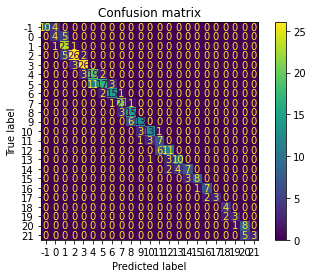

In [24]:
plot_confusion_matrix("round", predict, y_test)

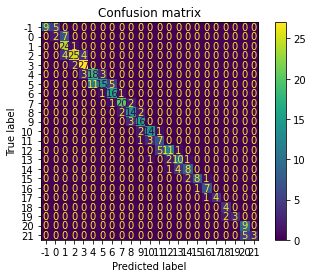

In [25]:
plot_confusion_matrix(0.33, predict, y_test)

### Random split

In [26]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [27]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [28]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 1.57
RMSE: 1.25
MAE: 1.02


In [29]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [30]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.57
RMSE: 1.25

Round type: round
MSE: 1.66
RMSE: 1.29

Round type: 0.33
MSE: 1.68
RMSE: 1.30

Round type: 0.45
MSE: 1.65
RMSE: 1.29



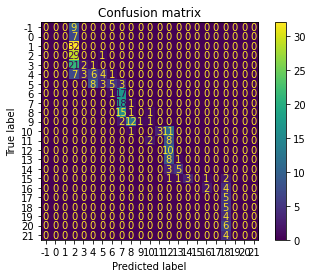

In [31]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

#### Tuning

In [32]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [33]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   3.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.6s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.1s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.1s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   3.0s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   2.6s
[CV] END ...max_depth=70, max_features=0.5, n_

[CV] END ..max_depth=110, max_features=0.4, n_estimators=700; total time=   2.3s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.6s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.0s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.0s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   1.9s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.3s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.0s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.0s
[CV] END ...max_depth=50, ma

[CV] END ...max_depth=20, max_features=0.4, n_estimators=500; total time=   1.6s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.5s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   1.1s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   1.1s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   1.0s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   2.6s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   3.3s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   3.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   4.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   3.5s
[CV] END ...max_depth=20, ma

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [34]:
rmse, mse, mae = assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.15
RMSE test: 0.37
MSE test: 0.13
MAE test: 0.24



In [35]:
results.loc[4] = ["random", "RandomizedSearchCV", len(X_test.columns), mse, rmse, mae]

### Attempt to decrease overfitting
Change max_depth to 13

In [36]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=800, max_features=0.5, max_depth=13
)
rf.fit(X_train_random_split, y_train_random_split)
rmse, mse, mae = assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.15
RMSE test: 0.37
MSE test: 0.13
MAE test: 0.24



In [37]:
results.loc[5] = [
    "random",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

Check rounded predictions

In [38]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.13
RMSE: 0.37

Round type: round
MSE: 0.17
RMSE: 0.41

Round type: 0.33
MSE: 0.20
RMSE: 0.44

Round type: 0.45
MSE: 0.18
RMSE: 0.42



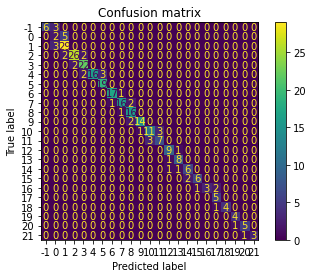

In [39]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

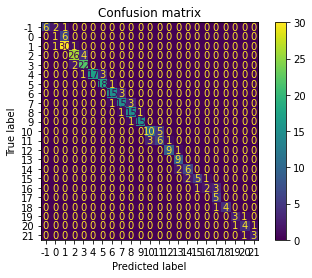

In [40]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

## Summary

In [41]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,2.116940,1.454971,1.160199
1,chronological,RandomizedSearchCV,13,0.255680,0.505648,0.335753
2,chronological,minimalise_overfitting,13,0.255801,0.505768,0.340095
3,random,normal,13,1.568874,1.252547,1.016585
4,random,RandomizedSearchCV,13,0.134225,0.366367,0.239901
5,random,minimalise_overfitting,13,0.133381,0.365213,0.238853


In [42]:
from training.results import plot_summary

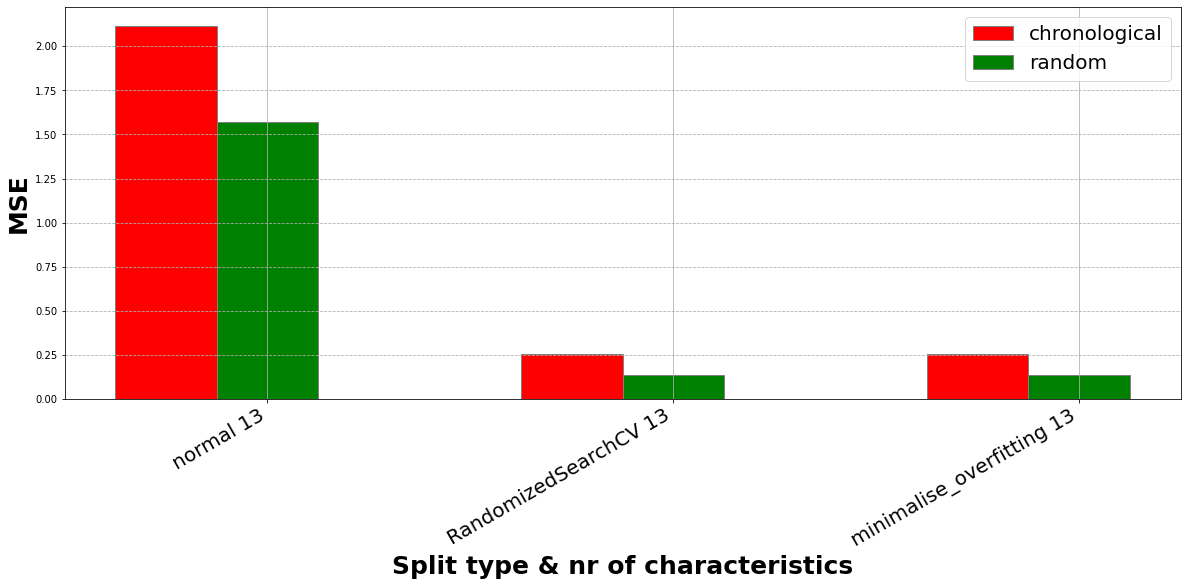

In [43]:
plot_summary(results, "MSE")

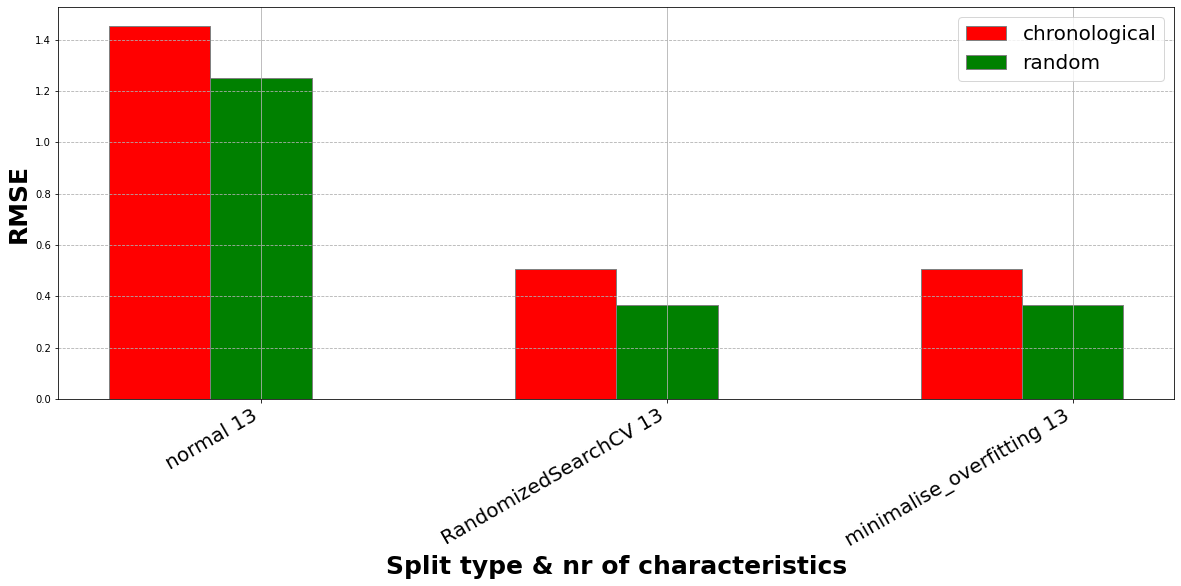

In [44]:
plot_summary(results, "RMSE")

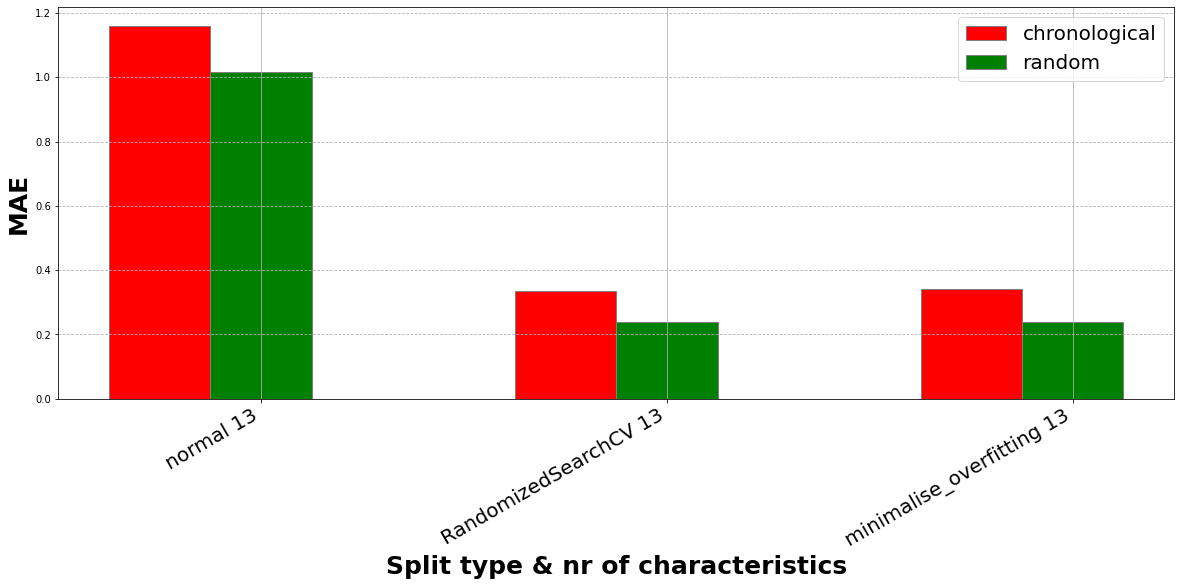

In [45]:
plot_summary(results, "MAE")

In [46]:
results.to_json("./random_forest_second_results.json")